In [1]:
import os
import pickle

import madmom
import numpy as np
import yaml
from alive_progress import alive_it
from fastai.data.transforms import get_files
from loguru import logger as log
from scipy import signal, stats
from matplotlib import pyplot as plt
from functools import partial

/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = "../data/raw/train/ff123_eb_andul_short.wav"
params = {
    "featurize": {
        "fps": 100
    }
}
fs = madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        )(file)

In [3]:
fs.shape

(692, 2048)

In [4]:
class SuperFluxProcessor(madmom.processors.SequentialProcessor):
    def __init__(self, num_bands=24, diff_max_bins=3, positive_diffs=True, fps=10.0):
        # define the processing chain
        spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogramProcessor(
            num_bands=num_bands, fps=fps
        )
        diff = madmom.audio.spectrogram.SpectrogramDifferenceProcessor(
            diff_max_bins=diff_max_bins, positive_diffs=positive_diffs
        )
        from functools import partial

        mean = partial(np.mean, axis=1)
        # sequentially process everything
        super(SuperFluxProcessor, self).__init__([spec, diff, mean])

In [5]:
stft = madmom.audio.stft.ShortTimeFourierTransform(fs)
spec = madmom.audio.spectrogram.Spectrogram(stft)
filt = madmom.audio.spectrogram.FilteredSpectrogram(spec, num_bands=24)
log = madmom.audio.spectrogram.LogarithmicSpectrogram(filt)
diff = madmom.audio.spectrogram.SpectrogramDifference(log, diff_max_bins=3, positive_diffs=True)
superflux_1 = np.mean(diff, axis=1)

In [6]:
len(superflux_1)

692

In [7]:
superflux = madmom.processors.SequentialProcessor(  # alternative: sound_pressure_level
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        madmom.audio.stft.ShortTimeFourierTransformProcessor(),
        madmom.audio.spectrogram.SpectrogramProcessor(),
        madmom.audio.spectrogram.FilteredSpectrogramProcessor(num_bands=24),
        madmom.audio.spectrogram.LogarithmicSpectrogramProcessor(),
        madmom.audio.spectrogram.SpectrogramDifferenceProcessor(diff_max_bins=3, positive_diffs=True),
        partial(np.mean, axis=1)
    ]
)(file)

In [8]:
superflux.shape

(692,)

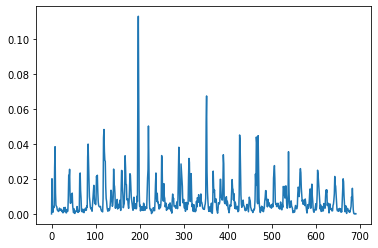

In [9]:
plt.plot(superflux)

In [10]:
energy = madmom.processors.SequentialProcessor(  # alternative: sound_pressure_level
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        madmom.audio.signal.energy,
    ]
)(file)

In [35]:
len(energy), energy.shape

(692, (692,))

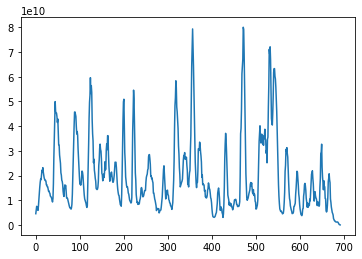

In [12]:
plt.plot(energy)

In [13]:
rms = madmom.processors.SequentialProcessor(  # alternative: sound_pressure_level
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        madmom.audio.signal.root_mean_square,
    ]
)(file)

In [37]:
len(rms), rms.shape

(692, (692,))

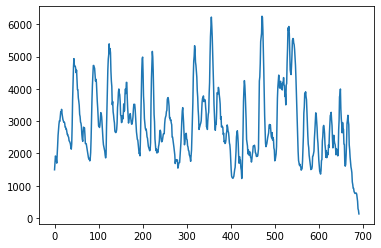

In [15]:
plt.plot(rms)

In [16]:
sound_preassure_level = madmom.processors.SequentialProcessor(  # alternative: sound_pressure_level
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        madmom.audio.signal.sound_pressure_level,
    ]
)(file)

In [38]:
len(sound_preassure_level), sound_preassure_level.shape

(692, (692,))

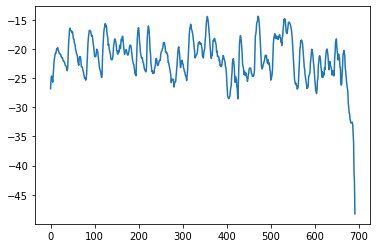

In [18]:
plt.plot(sound_preassure_level)

In [19]:
welch =  madmom.processors.SequentialProcessor(
[
    madmom.audio.signal.FramedSignalProcessor(
        fps=params["featurize"]["fps"]
    ),
    lambda fs: signal.welch(fs)[1],  # only return the spectral density,
    partial(np.mean, axis=1)
]
)(file)

In [40]:
len(welch), welch.shape

(692, (692,))

In [21]:
welch.shape

(692,)

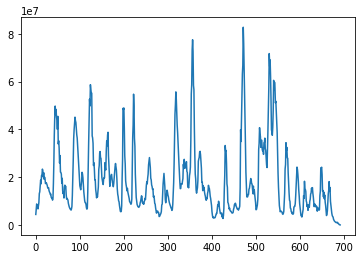

In [22]:
plt.plot(welch)

In [23]:
mean = madmom.processors.SequentialProcessor(
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        partial(np.mean, axis=1)
        #lambda fs: list(map(stats.gmean,fs)),
    ]
)(file)

In [41]:
len(mean), mean.shape

(692, (692,))

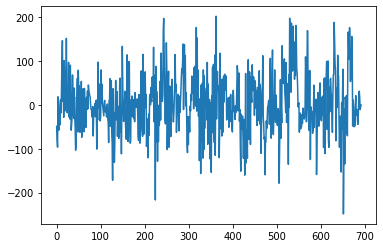

In [25]:
plt.plot(mean)

In [26]:
kurtosis = madmom.processors.SequentialProcessor(
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        lambda fs: list(map(stats.kurtosis,fs)),
    ]
)(file)

In [43]:
len(kurtosis)

692

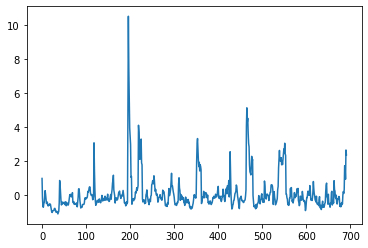

In [28]:
plt.plot(kurtosis)

In [29]:
skew = madmom.processors.SequentialProcessor(
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        lambda fs: list(map(stats.skew,fs)),
    ]
)(file)

In [30]:
len(skew)

692

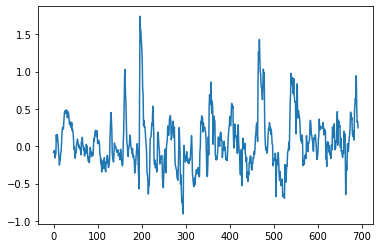

In [31]:
plt.plot(skew)

In [32]:
variation = madmom.processors.SequentialProcessor(
    [
        madmom.audio.signal.FramedSignalProcessor(
            fps=params["featurize"]["fps"]
        ),
        lambda fs: list(map(stats.variation,fs)),
    ]
)(file)

In [33]:
len(variation)

692

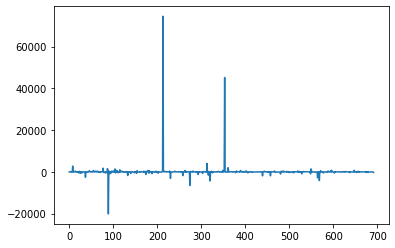

In [34]:
plt.plot(variation)